# Transmission line simulation with pysonnet
Let's setup the notebook. Define the full path (including the file name) of the sonnet file we want to make, and define the sonnet directory. We will need them later to run the project.

In [1]:
import logging
import numpy as np
import pysonnet as ps
# gdspy is available via 'pip install gdspy'
# or at https://github.com/heitzmann/gdspy
import gdspy as gp

sonnet_file_path = r"C:/Users/slab/Desktop/Yueheng_Sonnet/test.son"
path_to_sonnet = r"C:/Program Files/Sonnet Software/18.56/"

# Set up logging to the console
log = logging.getLogger()
log.setLevel(logging.INFO) # Only prints project.run() information. Set to logging.DEBUG for more detail
log.addHandler(logging.StreamHandler())

## Make a simple geometry with gdspy
We can make a cool wavy transmission line using the gdspy.Path class

The result can be easily viewed using gdspy's built in layout viewer (uncomment the last line)

In [2]:
# Geometric constants
box_x, box_y = 100, 100  # size of the box
width = 5  # transmission line width
layer = 0  # layer for gds format
datatype = 1  # datatype for gds format

# Initialize the path
path = gp.Path(width, initial_point=(box_x / 3, 0))

# Define the cosine path and it's derivative
def path_function(t):
    return -box_x / 6 * (np.cos(np.pi * t) - 1), t * box_y

def d_path_function(t):
    return np.pi * box_x / 6 * np.sin(np.pi * t), box_y

path.parametric(path_function, curve_derivative=d_path_function,
                layer=layer, datatype=datatype)

# Add the path to a cell
cell = gp.Cell('feedline', exclude_from_current=True)
cell.add(path);

# Show the result
#gp.LayoutViewer(cells=cell)

## Configure the project settings
The first step is to pick the box settings and the materials that we will use for the sonnet simulation

In [3]:
# The GeometryProject is the most basic Sonnet project type
project = ps.GeometryProject()

# The default length unit for Sonnet is mils,so let's change it
project.set_units(length='um')

# Then we can set up the box
project.setup_box(box_x, box_y, 200, 200)

# Define the metal types and if they are on the box top/bottom
# high kinetic inductance superconductor
project.define_metal("general", "PtSi", ls=21)
# low kinetic inductance superconductor
project.define_metal("general", "Nb", ls=0.08)
project.set_box_cover("free space", top=True)
project.set_box_cover("custom", name="Nb", bottom=True)

# Lets add a dielectric layer under the microstrip and air above
project.add_dielectric("air", layer, thickness=1000)
project.add_dielectric("silicon", layer + 1, thickness=100,
                       epsilon=11.9, dielectric_loss=0.004,
                       conductivity=4.4e-4)

# We can also define technology layers
project.define_technology_layer("metal", "microstrip", layer,
                                "PtSi", fill_type="diagonal")

# We also might want to see the current density
project.set_options(current_density=True)

## Load the geometry into a pysonnet project
The polygons can be extracted using the get_polygons() method for the Cell, CellReference or CellArray.

The by_spec keyword is useful for separating different layers and datatypes to assign groups of polygons to different Sonnet layers with different properties. 

In [4]:
polygons = cell.get_polygons(by_spec=True)
# Pick the polygons that I want
microstrip_polygons = polygons[(layer, datatype)]

We can now add the polygons and ports to our project.

In [5]:
project.add_polygons("metal", microstrip_polygons,
                     tech_layer="microstrip")
project.add_port("standard", 1, 2 * box_x / 3, box_y,
                 resistance=50)
project.add_port("standard", 2, box_x / 3, 0, resistance=50)

## Set up the simulation
After defining the box, materials, geometry, and ports, we can choose what kind of simulation we are doing.

In [6]:
project.add_syz_parameter_file(
    file_type='touchstone',    # write a .sNp file
    file_name='test.s2p'       # name it test.s2p (default: $BASENAME.s2p)
)

In [7]:
# Add the frequency sweep to the project
project.add_frequency_sweep("abs", f1=4, f2=5)
# Select an analysis (doesn't need to be done if running the project)
project.set_analysis("frequency sweep")
# Make the sonnet file
project.make_sonnet_file(sonnet_file_path)

# Run the project
# project.run("frequency sweep")

In [8]:
# Locate Sonnet
project.locate_sonnet(path_to_sonnet)

Testing sonnet
ELECTROMAGNETIC ANALYSIS OF 3-D PLANAR CIRCUITS
Version 18.56
Copyright (c) 1986-2022 Sonnet Software Inc.
All rights reserved.
Run 1:  Fri May 23 14:24:04 2025.  uchicago4.1.85014.
Em version 18.56 (64-bit Windows) on ziqian-li-mem local.
Project:  C:\Users\slab\Desktop\pysonnet\examples\test.son.
Begin electromagnetic simulation using frequency sweep:
Single Frequency = 1 GHZ
Frequency:  1 GHZ
Subsectioning time:  0.001 seconds.
Circuit requires 1 subsection and 1 MB of memory.
Threads:  using 64 thread(s), 64 core(s) available.
Waveguide mode time:  0.004 seconds.
Matrix fill time:  0.022 seconds.
Matrix solve time:  0.026 seconds.
De-embedded S-Parameters. 50 Ohm Port Terminations.
Magnitude/Angle. Touchstone Format. Matrix Order (line #1: S11 S12 S13 ...).
1.00000000 1.000000 -0.260
! P1 F=1.0 Eeff=(1.00693 + j0) Z0=(152.57 + j0)
Total time per frequency:  0.159 seconds.
Post-Analysis information for em run 1:
Total time for 1 frequency:  0.184 seconds.
Em errors de

In [9]:
# Run the project
project.run("frequency sweep")

ELECTROMAGNETIC ANALYSIS OF 3-D PLANAR CIRCUITS
Version 18.56
Copyright (c) 1986-2022 Sonnet Software Inc.
All rights reserved.
Run 1:  Fri May 23 14:24:08 2025.  .
Em version 18.56 (64-bit Windows) on ziqian-li-mem local.
Project:  C:\Users\slab\Desktop\Yueheng_Sonnet\test.son.
Begin electromagnetic simulation using frequency sweep:
ABS Start = 4, Stop = 5 GHZ
Frequency:  4 GHZ
Subsectioning time:  0.029 seconds.
Circuit requires 2320 subsections and 44 MB of memory.
Threads:  using 64 thread(s), 64 core(s) available.
Waveguide mode time:  0.018 seconds.
Matrix fill time:  0.333 seconds.
Matrix solve time:  0.454 seconds.
De-embedded S-Parameters. 50 Ohm Port Terminations.
Magnitude/Angle. Touchstone Format. (S11 S21 S12 S22).
4.00000000 0.128018 81.907 0.991746 -8.104 0.991746 -8.104 0.128018 81.907
! P1 F=4.0 Eeff=(44.2929 - j0.170233) Z0=(224.305 + j0.431071)
! P2 F=4.0 Eeff=(44.2929 - j0.170233) Z0=(224.305 + j0.431071)
Total time per frequency:  1 second.
Frequency:  5 GHZ
Wavegu

In [10]:
# 3) Load the .s2p and plot S12
from pysonnet.outputs import SYZParameter
#import numpy as np
import matplotlib.pyplot as plt


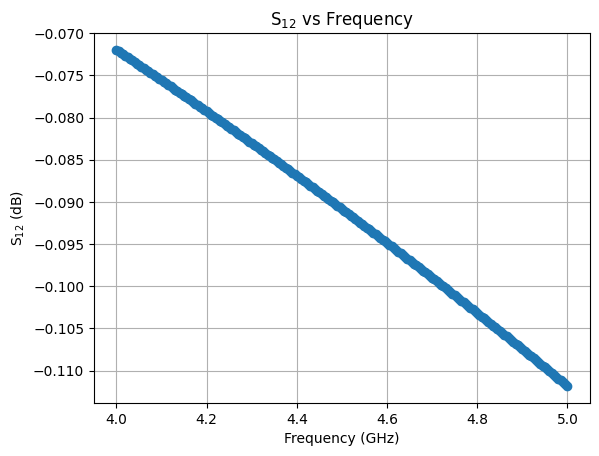

In [12]:
# read in the Touchstone file you just generated
sp = SYZParameter.from_touchstone('C:/Users/slab/Desktop/Yueheng_Sonnet/test.s2p')
# :contentReference[oaicite:1]{index=1}

# frequencies (GHz) and the 2×2 S-matrix (complex) array
f = sp.f                       # shape (N,) in GHz
S = sp.value                   # shape (N, 2, 2)

# pick out S12 = measurement at port 1 due to excitation at port 2
s12 = S[:, 0, 1]

# plot magnitude in dB
plt.figure()
plt.plot(f, 20*np.log10(np.abs(s12)), marker='o')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S$_{12}$ (dB)')
plt.title('S$_{12}$ vs Frequency')
plt.grid(True)
plt.show()

In [13]:
microstrip_polygons

[array([[ 30.83333333,   0.        ],
        [ 30.85423374,   1.62670825],
        [ 30.91687379,   3.2531355 ],
        [ 31.02107049,   4.87900539],
        [ 31.1665205 ,   6.50405064],
        [ 31.35280257,   8.12801709],
        [ 31.57938074,   9.75066724],
        [ 31.84560822,  11.37178313],
        [ 32.15073189,  12.99116847],
        [ 32.49389703,  14.60865003],
        [ 32.87415236,  16.22407829],
        [ 33.29045517,  17.83732744],
        [ 33.74167639,  19.44829464],
        [ 34.22660558,  21.05689896],
        [ 34.74395574,  22.6630797 ],
        [ 35.29236794,  24.26679457],
        [ 35.87041573,  25.86801761],
        [ 36.47660936,  27.466737  ],
        [ 37.10939982,  29.06295287],
        [ 37.76718275,  30.65667513],
        [ 38.44830223,  32.24792144],
        [ 39.15105453,  33.83671526],
        [ 39.87369175,  35.42308407],
        [ 41.37143105,  38.58866748],
        [ 42.92679611,  41.74491608],
        [ 44.52459919,  44.89205476],
        [ 47